In [1]:
import pandas as pd
import numpy as np
import torch as pt
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.datasets import LFWPairs
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
training = LFWPairs('./data/train', split='train', download=True, transform=transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

validating = LFWPairs('./data/validate', download=True, transform=transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

testing = LFWPairs('./data/test', split='test', download=True, transform=transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

100%|██████████| 243346528/243346528 [01:39<00:00, 2452696.50it/s]


Extracting ./data/train/lfw-py/lfw-funneled.tgz to ./data/train/lfw-py


100%|██████████| 56579/56579 [00:00<00:00, 818681.35it/s]


100%|██████████| 243346528/243346528 [02:11<00:00, 1845975.39it/s]


Extracting ./data/validate/lfw-py/lfw-funneled.tgz to ./data/validate/lfw-py


100%|██████████| 155335/155335 [00:00<00:00, 1090222.16it/s]


100%|██████████| 243346528/243346528 [02:19<00:00, 1739965.78it/s]


Extracting ./data/test/lfw-py/lfw-funneled.tgz to ./data/test/lfw-py


100%|██████████| 26002/26002 [00:00<00:00, 798613.76it/s]


In [3]:
torch.manual_seed(42)
training_set = DataLoader(training, batch_size=16, shuffle=True)
validation_set = DataLoader(validating, batch_size=16, shuffle=True)
testing_set = DataLoader(testing, batch_size=16, shuffle=True)

In [41]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=2),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=(1, 1)),
            nn.Conv2d(64, 192, kernel_size=(3, 3)),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(192, 192, kernel_size=(1, 1)),
            nn.Conv2d(192, 384, kernel_size=(3, 3)),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(384, 384, kernel_size=(1, 1)),
            nn.Conv2d(384, 256, kernel_size=(3, 3)),

            nn.Conv2d(256, 256, kernel_size=(1, 1)),
            nn.Conv2d(256, 256, kernel_size=(3, 3)),

            nn.Conv2d(256, 256, kernel_size=(1, 1)),
            nn.Conv2d(256, 256, kernel_size=(3, 3)),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),

            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
        )

        self.distance = nn.PairwiseDistance()
        self.fc2 = nn.Sigmoid()

    def forward_once(self, img):
        return self.fc1(self.cnn(img))

    def get_embeddings(self, img):
        return self.forward_once(img)

    def predict_from_embeddings(self, input1, input2):
        return self.fc2(self.distance(input1, input2))

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        dist = self.distance(out1, out2)
        return self.fc2(dist)

In [42]:
class Trainer:

    def __init__(self, model, criterion, optim, device):
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optim = optim
        self.device = device
        self.metrics = {
            'train_loss': [],
            'train_acc': [],
            'valid_loss': [],
            'valid_acc': []
        }

    def _calc_accuracy(self, preds, labels):
        total = 0
        correct = 0
        preds, labels = preds > 0.5, labels.type(torch.BoolTensor)
        for i, pred in enumerate(preds):
            correct += 1 if pred == labels[i] else 0
            total += 1
        return correct / total

    def _update_metrics(self, loss, accuracy, dataset_type="train"):
        self.metrics[f"{dataset_type}_loss"].append(loss.item())
        self.metrics[f"{dataset_type}_acc"].append(accuracy)

    def _train(self, dataset):
        self.model.train()
        for i, (img1, img2, labels) in enumerate(dataset):
            img1, img2, labels = img1.to(self.device), img2.to(self.device), labels.type(torch.FloatTensor).to(self.device)
            preds = self.model(img1, img2)
            loss = self.criterion(preds, labels)

            acc = self._calc_accuracy(preds, labels)
            self._update_metrics(loss, acc)

            loss.backward()
            self.optim.step()

    @torch.no_grad()
    def _valid(self, dataset):
        self.model.eval()
        for i, (img1, img2, labels) in enumerate(dataset):
            img1, img2, labels = img1.to(self.device), img2.to(self.device), labels.type(torch.FloatTensor).to(self.device)
            preds = self.model(img1, img2)

            loss = self.criterion(preds, labels)
            acc = self._calc_accuracy(preds, labels)
            self._update_metrics(loss, acc, 'valid')

    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

        ax1.plot(self.metrics["train_loss"], label='Train Loss')
        ax1.plot(self.metrics["valid_loss"], label='Validation Loss') if self.metrics["valid_loss"] else None
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Curves')
        ax1.legend()

        ax2.plot(self.metrics["train_acc"], label='Train Accuracy')
        ax2.plot(self.metrics["valid_acc"], label='Validation Accuracy') if self.metrics["valid_acc"] else None
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy Curves')
        ax2.legend()

        plt.show()

    def fit(self, epochs, train_set, valid_set=None, save_every=5):
        for epoch in tqdm(range(epochs)):
            self._train(train_set)
            if epoch % save_every == 0:
                torch.save(self.model.state_dict(), f"checkpoint_{epoch}")
            if valid_set:
                self._valid(valid_set)
        self.plot_metrics()


    @torch.no_grad()
    def predict(self, dataset, name="Test"):
        self.model.eval()
        accuracy = []
        for i, (img1, img2, labels) in tqdm(enumerate(dataset)):
            img1, img2, labels = img1.to(self.device), img2.to(self.device), labels.type(torch.FloatTensor).to(self.device)
            preds = self.model(img1, img2)

            accuracy.append(self._calc_accuracy(preds, labels))

        total_acc = sum(accuracy) / len(accuracy)
        print(f"{name} Accuracy: {total_acc}")
        return total_acc


In [43]:
torch.manual_seed(42)
PATH = './model_state.pt'
EPOCHS = 7

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseNetwork()
criterion = nn.BCELoss()
torch.load_state_dict(torch.load(PATH)) if exists(PATH) else None
optim = Adam(model.parameters())

100%|██████████| 7/7 [05:17<00:00, 45.36s/it]


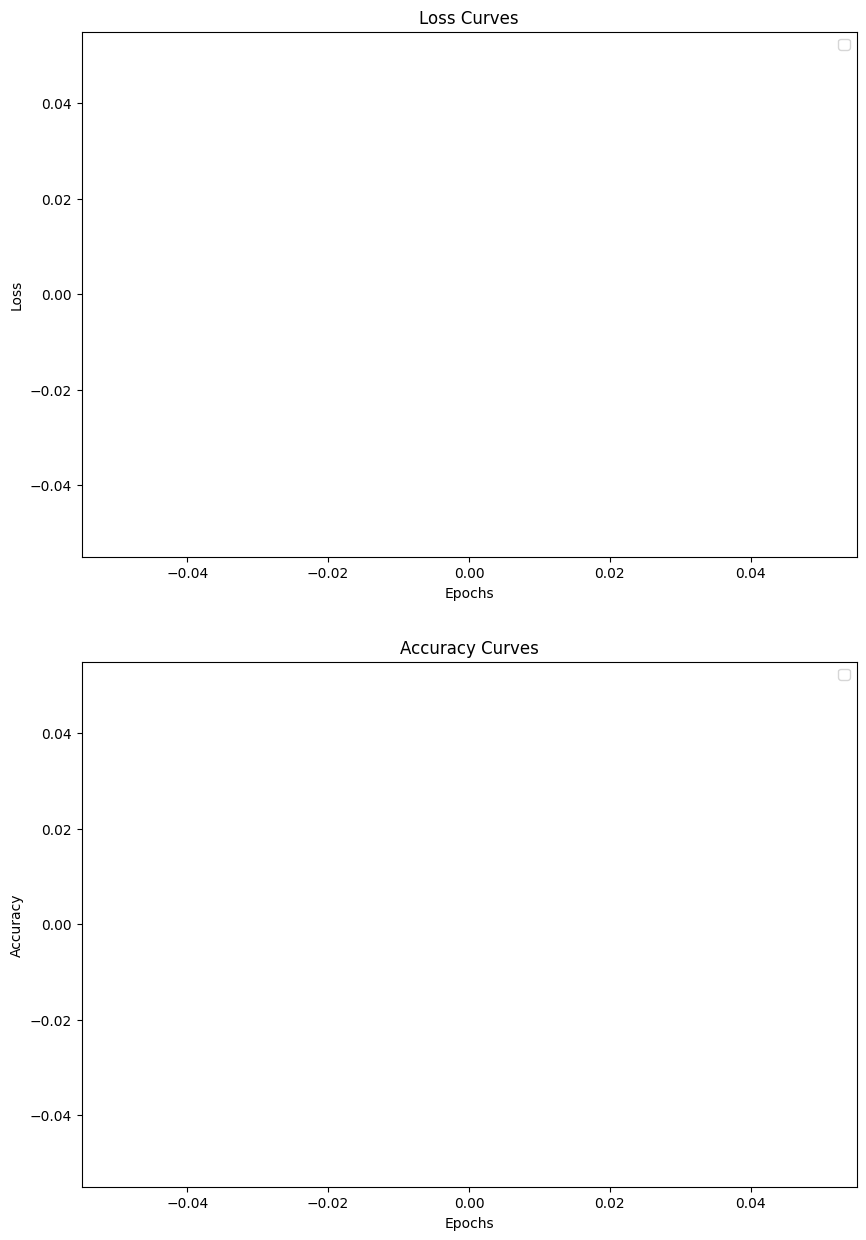

In [44]:
trainer = Trainer(model, criterion, optim, device)
trainer.fit(EPOCHS, training_set, validation_set)

In [45]:
train_acc = trainer.predict(training_set, "Train")
test_acc = trainer.predict(testing_set)

138it [00:13, 10.18it/s]


Train Accuracy: 0.5009057971014492


63it [00:05, 11.00it/s]

Test Accuracy: 0.5009920634920635


0.5009920634920635

In [ ]:
torch.save(model.state_dict(), PATH)